In [31]:
import warnings
warnings.filterwarnings("ignore")

import math
import io
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
  
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_msssim import ssim

from typing import List, Dict
from masks import ring_mask, box_mask, dot_mask
from load_compression_models import (
    my_bmshj2018_factorized, 
    my_bmshj2018_factorized_relu,
    my_bmshj2018_hyperprior,
    my_cheng2020_anchor,
    my_cheng2020_attn,
    my_mbt2018,
    my_mbt2018_mean
)
from compressai.losses import RateDistortionLoss

In [32]:
# Disable TF32 Tensor Cores
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

### Load the Compression Networks

In [33]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.backends.mps.is_available():
    'mps'

In [34]:
models = {
    'my_bmshj2018_factorized_relu': my_bmshj2018_factorized_relu(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_bmshj2018_factorized'     : my_bmshj2018_factorized(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_bmshj2018_hyperprior'     : my_bmshj2018_hyperprior(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_cheng2020_anchor'         : my_cheng2020_anchor(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_cheng2020_attn'           : my_cheng2020_attn(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_mbt2018'                  : my_mbt2018(quality=2, pretrained=True).train().to(torch.float32).to(device),
    'my_mbt2018_mean'             : my_mbt2018_mean(quality=2, pretrained=True).train().to(torch.float32).to(device)
}
net = models['my_bmshj2018_factorized_relu']
print(f'Parameters: {sum(p.numel() for p in net.parameters())}')

Parameters: 2998147


### Load the Dataset

In [35]:
# Define the transformations
img_WH = 256
transform = transforms.Compose([
    transforms.Resize((img_WH, img_WH)),
    transforms.ToTensor(),
])

# Load the CelebA dataset
dataset = datasets.CelebA(root='./data', split='train', transform=transform, download=True)

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Files already downloaded and verified


### Run Attack

In [36]:
class StatsMeter:
    # Utility function to track statistics of a variable
    # over time
    def __init__(self) -> None:
        self.data = []
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.max = 0
        self.min = float('inf')

    def update(self, val : float, n : int = 1) -> None:
        self.count += n
        self.data.append(val)
        self.sum = sum(self.data)
        self.avg = self.sum / len(self.data)
        self.max = max(self.data)
        self.min = min(self.data)

In [37]:
class Attack:
    def __init__(
            self, 
            model: torch.nn.Module, 
            batch_size: int,
            device: str
        ):
        self.model = model
        self.batch_size = batch_size
        self.device = device

        # Evaluation metrics
        self.success = []
        self.psnr = []
        self.ssim = []
        self.l2 = []

    def init_mask(
            self,
            image: torch.Tensor,
            mask_type: str = 'dot',
        ) -> None:
        if mask_type == 'box':
            mask = box_mask()
        elif mask_type == 'ring':
            num_rings = 50
            ring_width = 1
            ring_separation = 5
            mask = ring_mask(image, num_rings=num_rings, ring_width=ring_width, ring_separation=ring_separation)
        elif mask_type == 'dot':
            vertical_skip = 2 
            horizontal_skip = 3
            mask = dot_mask(image, vertical_skip=vertical_skip, horizontal_skip=horizontal_skip)
        return mask
    
    def criterion(
            self,
            src_img: torch.Tensor, 
            target_img: torch.Tensor
        ) -> torch.Tensor:
        mse = F.mse_loss(src_img, target_img) 
        cos_sim = F.cosine_similarity(src_img.view(1, -1), target_img.view(self.batch_size, -1), dim=1).mean()
        loss = mse + ((1 - cos_sim) / 2)
        return loss

    def run(
            self,
            src_img: torch.Tensor, 
            target_img: torch.Tensor, 
            optimizer: torch.optim.Optimizer, 
            scheduler: torch.optim.lr_scheduler._LRScheduler, 
            num_steps: int, 
            mask: torch.Tensor = None
        ) -> List:
        # Move images to the same device as the model
        src_img = src_img.to(self.device)
        target_img = target_img.to(self.device)
        mask = mask.to(self.device)
        # Get the embedding of the source image and make a copy of the target
        src_emb = self.model.forward(src_img)['y_hat']

        # Track the best performance
        best_img = None
        loss_tracker = StatsMeter()

        pbar = tqdm(range(num_steps))
        for iter in pbar:  
            out = self.model.forward(target_img)
            target_emb = out['y_hat']
            loss = self.criterion(src_emb, target_emb)
            pbar.set_description(f"[Running attack]: Loss {loss.item()}")
            optimizer.zero_grad()
            target_img.grad,  = torch.autograd.grad(loss, [target_img])
            if mask is not None:
                target_img.grad *= mask
            optimizer.step()
            scheduler.step()
            loss_tracker.update(loss.item())

            # Save the image that achieved the best performance
            if loss.item() == loss_tracker.min:
                best_img = target_img

        return best_img, loss_tracker
    
    def batch_eval(
            self, 
            x: torch.Tensor, 
            x_adv: torch.Tensor,
            output: torch.Tensor,
        ) -> None:
        success = self._calculate_success_rate(x, x_adv)
        metrics = self._calculate_psnr_ssim_l2(x, output)

        self.success.append(success)
        self.l2.append(metrics['l2'])
        self.ssim.append(metrics['ssim'])
        self.psnr.append(metrics['psnr'])
        print(f"BATCH METRICS\nSuccess: {success}/{self.batch_size}\nNormalized L2 Dist: {metrics['l2']}\nSSIM: {metrics['ssim']}\nPSNR: {metrics['psnr']}\n")

    def global_eval(self) -> None:
        def calculate(metric):
            return sum(metric) / len(metric)
        asr = calculate(self.success) / self.batch_size
        l2 = calculate(self.l2)
        ssim = calculate(self.ssim)
        psnr = calculate(self.psnr)
        print(f"\nGLOBAL METRICS\nSuccess: {asr}\nNormalized L2 Dist: {l2}\nSSIM: {ssim}\nPSNR: {psnr}")

    def _calculate_success_rate(
            self, 
            src_img: torch.Tensor, 
            adv_imgs: torch.Tensor
        ) -> int:
        success = 0
        # Calculate the hamming distance between the compressed x and x_adv
        with torch.no_grad():
            src_bytes = self.model.compress(src_img)['strings'][0][0]
            x_adv_bytes = self.model.compress(adv_imgs)['strings'][0]
        for adv_bytes in x_adv_bytes:
            hamming_dist = 0
            if len(adv_bytes) != len(src_bytes):
                continue
            for x_byte, adv_byte in zip(src_bytes, adv_bytes):
                hamming_dist += bin(x_byte^adv_byte).count('1')
            if hamming_dist == 0:
                success += 1
        return success
    
    def _calculate_psnr_ssim_l2(
            self, 
            img1: torch.Tensor, 
            img2: torch.Tensor
        ) -> Dict:
        def _psnr(img1, img2, max_val=1.0):
            # img1 and img2 should be of shape (batch_size, channels, height, width) and normalized to [0, 1] range
            mse = F.mse_loss(img1, img2)
            psnr = 10 * torch.log10(max_val / torch.sqrt(mse))
            return psnr
        
        normalized_l2_dist, struct_sim, psnr = [], [], []
        for i in range(self.batch_size):
            normalized_l2_dist.append(torch.norm(img1 - img2[i]) / img1.numel())
            struct_sim.append(ssim(img1, img2[i].unsqueeze(0)))
            psnr.append(_psnr(img1, img2[i]))
        return {
            'l2': torch.tensor(normalized_l2_dist).mean(),
            'ssim': torch.tensor(struct_sim).mean(),
            'psnr': torch.tensor(psnr).mean()
        }

In [38]:
num_steps = 10000
mask_type = 'dot'
num_batches = 5
lr = 3e-2

# Source Image and its compressed bytes
x = dataset[0][0].unsqueeze(0).to(device)
with torch.no_grad():   
    x_bytes = net.compress(x)['strings'][0][0]
    
# Initialize the attack
attack = Attack(model=net, batch_size=batch_size, device=device)
for i, (x_hat, _) in enumerate(dataloader):
    x_hat = x_hat.to(device)
    x_src = x_hat.clone()
    x_hat.requires_grad = True
    mask = attack.init_mask(x_hat, mask_type='dot')

    # Run the attack and produce an adversarial image y_hat
    optimizer = torch.optim.Adam([x_hat], lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_steps/10)
    x_adv, loss_tracker = attack.run(x, x_hat, optimizer=optimizer, scheduler=scheduler, num_steps=num_steps, mask=mask)
 
    # Pass the adv images through the compression network and see the result
    with torch.no_grad():
        output = net.forward(x_adv)['x_hat']

    # Evaluate the performance of the attack on this batch of data
    attack.batch_eval(x, x_adv, output)    
    if i == num_batches - 1:
        break

# Evaluate the performance of the attack across the entire dataset
attack.global_eval()

[Running attack]: Loss 7.95304799794394e-08: 100%|██████████| 10000/10000 [13:40<00:00, 12.19it/s] 


BATCH METRICS
Success: 32/32
Normalized L2 Dist: 9.561284241499379e-05
SSIM: 0.9999364018440247
PSNR: 13.726847648620605



[Running attack]: Loss 8.248862570781057e-08: 100%|██████████| 10000/10000 [13:41<00:00, 12.18it/s]


BATCH METRICS
Success: 30/32
Normalized L2 Dist: 9.564952051732689e-05
SSIM: 0.9999364018440247
PSNR: 13.725181579589844



[Running attack]: Loss 8.290476927186319e-08: 100%|██████████| 10000/10000 [13:42<00:00, 12.16it/s]


BATCH METRICS
Success: 32/32
Normalized L2 Dist: 9.55870928009972e-05
SSIM: 0.9999364614486694
PSNR: 13.728019714355469



[Running attack]: Loss 8.264562012527676e-08: 100%|██████████| 10000/10000 [13:40<00:00, 12.19it/s]


BATCH METRICS
Success: 32/32
Normalized L2 Dist: 9.560485341353342e-05
SSIM: 0.9999365210533142
PSNR: 13.727209091186523



[Running attack]: Loss 8.890215497103782e-08: 100%|██████████| 10000/10000 [13:40<00:00, 12.18it/s]


BATCH METRICS
Success: 31/32
Normalized L2 Dist: 9.556555596645921e-05
SSIM: 0.999936580657959
PSNR: 13.728996276855469


GLOBAL METRICS
Success: 0.98125
Normalized L2 Dist: 9.56039730226621e-05
SSIM: 0.9999364614486694
PSNR: 13.727251052856445


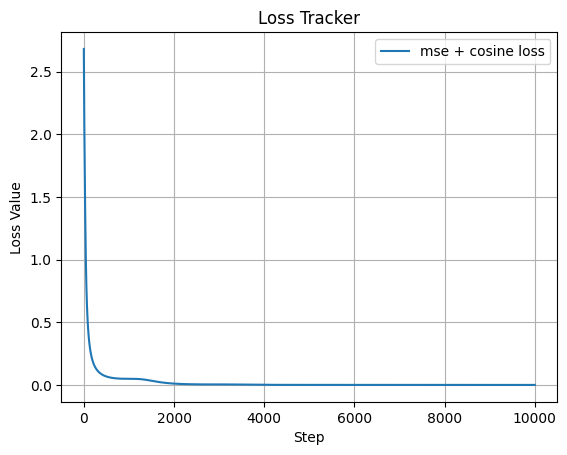

In [39]:
# Show how the loss changed during optimization
plt.plot(loss_tracker.data, label='mse + cosine loss')
plt.xlabel('Step')
plt.ylabel('Loss Value')
plt.title('Loss Tracker')
plt.legend()
plt.grid()
plt.show()

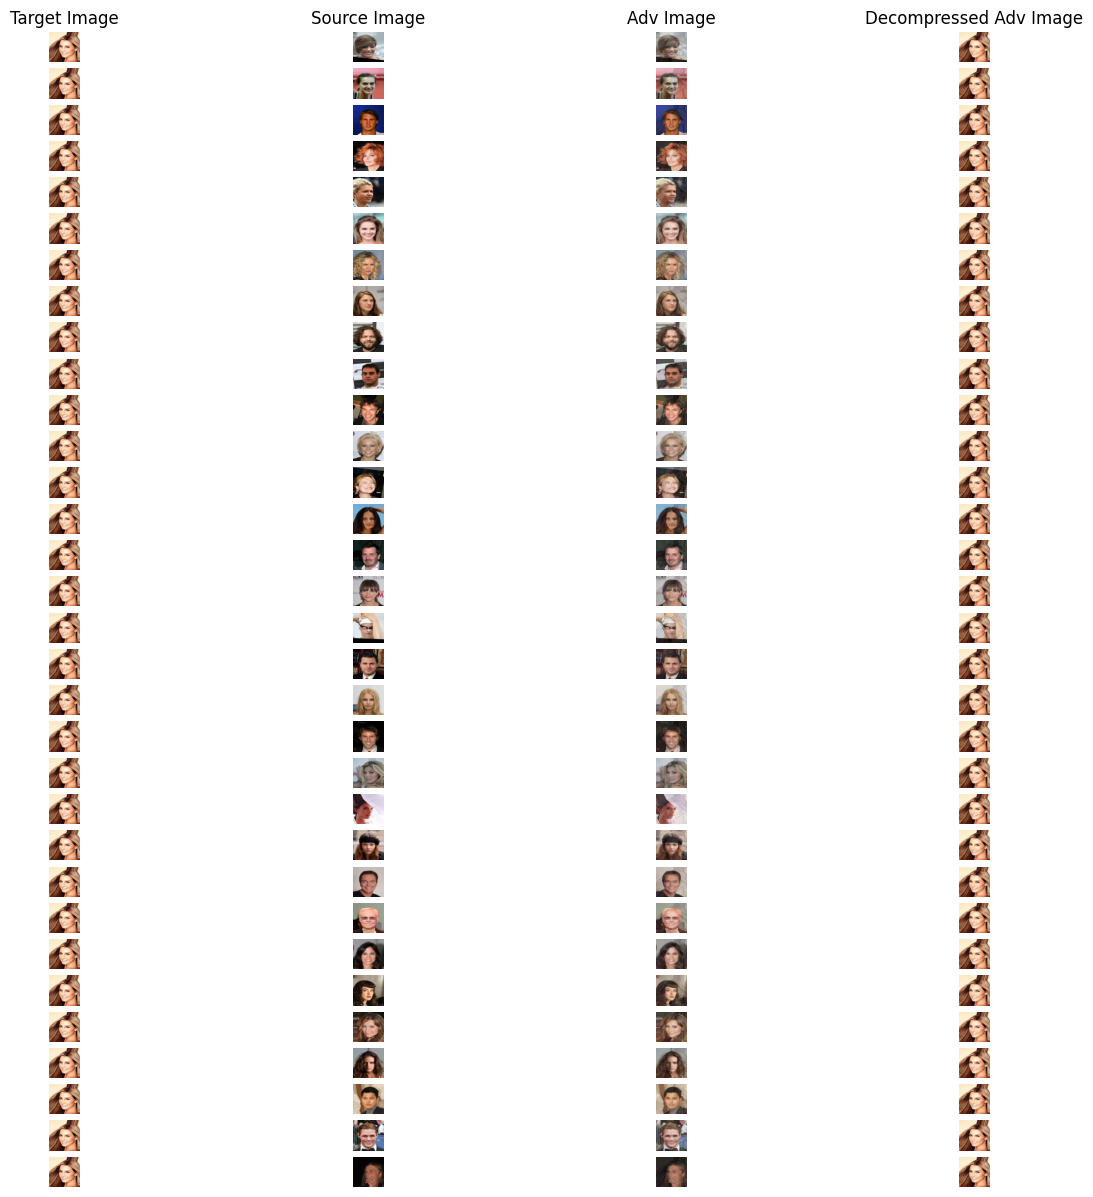

In [40]:
# Create a figure to hold the subplots
fig, axs = plt.subplots(batch_size, 4, figsize=(15, 15))  # num_sources rows, 4 columns
labels = ['Target Image', 'Source Image', 'Adv Image', 'Decompressed Adv Image']

for idx in range(batch_size):
    images = [x, x_src[idx], x_adv[idx], output[idx]]
    
    # Iterate over the images and axes to plot each image
    for img_idx, ax in enumerate(axs[idx] if batch_size > 1 else axs):  # Use idx for outer loop, img_idx for inner
        img = images[img_idx].clip(0, 1).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Change the shape to [H, W, C]
        ax.imshow(img)
        if idx == 0:
            ax.set_title(labels[img_idx])
        ax.axis('off')  # Hide axis

plt.show()

### Performance Metrics

Similarity between the adversarial output of the network and the target image

In [41]:
def calculate_psnr(img1, img2, max_val=1.0):
    # img1 and img2 should be of shape (batch_size, channels, height, width) and normalized to [0, 1] range
    mse = F.mse_loss(img1, img2)
    psnr = 10 * torch.log10(max_val / torch.sqrt(mse))
    return psnr

In [42]:
# Pass the adv image through the compression network and see the result
with torch.no_grad():
    output = net.forward(x_adv)['x_hat']

In [43]:
normalized_l2_dist, struct_sim, psnr = [], [], []
for i in range(batch_size):
    normalized_l2_dist.append(torch.norm(x - output[i]) / (3 * img_WH * img_WH))
    struct_sim.append(ssim(x, output[i].unsqueeze(0)))
    psnr.append(calculate_psnr(x, output[i]))

print(f'Normalized L2 Dist: {torch.tensor(normalized_l2_dist).mean()}\nSSIM: {torch.tensor(struct_sim).mean()}\nPSNR: {torch.tensor(psnr).mean()}')


Normalized L2 Dist: 9.557667362969369e-05
SSIM: 0.999936580657959
PSNR: 13.728489875793457


Similarity between the source image and the adversarial image

In [44]:
normalized_l2_dist, struct_sim, psnr = [], [], []
for i in range(batch_size):
    normalized_l2_dist = torch.norm(x_src[i] - x_adv[i]) / (3 * img_WH * img_WH)
    struct_sim = ssim(x_src[i].unsqueeze(0), x_adv[i].unsqueeze(0))
    psnr = calculate_psnr(x_src[i], x_adv[i])

print(f'Normalized L2 Dist: {torch.tensor(normalized_l2_dist).mean()}\nSSIM: {torch.tensor(struct_sim).mean()}\nPSNR: {torch.tensor(psnr).mean()}')


Normalized L2 Dist: 0.005780357867479324
SSIM: 0.8723443746566772
PSNR: -4.08755350112915
